In [1]:
from nalgene.generate import *

parsed, _, _ = generate_from_file('.', 'grammar.nlg')

> Change the volume high.
( %
    ( %setVolume (0, 3, 4)
        ( $up_down (3, 3, 1) high ) ) )



In [2]:
def descend(node, fn, child_type='phrase', returns=None):
    if returns is None: returns = []
    returned = fn(node)
    returns.append(returned)

    for child in node.children:
        if (child_type is None) or (child.type == child_type):
            descend(child, fn, child_type, returns)
    
    return returns

In [3]:
def ascend(node, fn):
    if node.parent is None:
        return fn(node)
    else:
        return ascend(node.parent, fn)

## Building input and output vocabularies

To find all input vocabulary tokens, we can traverse the parsed nalgene tree and copy all `word` type tokens.

In [4]:
input_tokens = []

def print_tokens(node):
    if node.type == 'word':
        input_tokens.append(node.key)

descend(parsed, print_tokens, None)

input_tokens = list(set(input_tokens))
input_tokens = ['EOS'] + input_tokens
print(input_tokens)

['EOS', 'Heroes', 'Machine', 'Hayko', 'Skrillex', 'Own', 'Summer', 'Funky', 'Breeze', 'Yakup', 'Coldplay', 'Got', 'Day', 'Seaside', 'Such', 'volume', 'Remaster', '10', 'get', 'Of', 'Melody', 'Dogulu', 'Original', 'Louie', 'Eyes', 'maia', 'Train', 'shit', 'music', 'Had', '3', 'plox', '6', 'Pinhani', 'Reha', 'Introduction', 'turn', 'change', 'by', 'Sleeps', 'Darkness', 'please', 'Furtado', 'Agua', 'and', 'Jizz', 'Out', 'Army', 'state', 'Attack', 'Athena', 'Sexbomb', '12', 'Stripes', 'Black', '2', 'put', 'Firestarter', 'Sezen', 'than', 'low', 'Iris', 'Morrissey', 'Take', 'red', 'Massive', 'coffee', 'Daydream', 'Remixed', "what's", 'hot', '11', 'Any', 'Diken', 'Duman', 'yen', 'is', 'the', 'Naive', 'Space', 'kitchen', 'Back', 'Breathe', 'With', 'bathroom', 'Night', 'Her', 'Best', 'For', 'Hate', 'Edit', '16', 'Your', 'My', 'you', 'Sheriff', 'light', 'outside', 'Turning', 'Imbruglia', 'Go', 'Seven', 'Annique', 'When', 'Rappers', 'Boogie', 'pretty', 'what', 'um', 'Blame', 'Shades', 'then', 'Ba

For output tokens, we can just take the top level node names that are either phrases or variables.

In [5]:
output_tokens = [child.key for child in parsed.children if child.type in ['phrase', 'variable']]
output_tokens = ['EOS'] + output_tokens
print(output_tokens)

['EOS', '%', '%if', '%sequence', '%condition', '%checkValue', '%getNumberValue', '%getValue', '%action', '%checkLightState', '%checkSwitchState', '%getLightState', '%getSwitchState', '%getTemperature', '%getPrice', '%setLightState', '%light_state', '%setSwitchState', '%setTemperature', '%setVolume', '%playMusic', '$operator', '$asset', '$room', '$light', '$switch', '$on_off', '$up_down', '$color', '$value', '$artist', '$song']


## Getting input and target data for nodes

In [6]:
def words_for_position(words, position):
    if position is None:
        return words
    start, end, length = position
    return words[start : end + 1]

In [7]:
def relative_position(node, parent):
    if parent.position is None:
        return node.position
    return node.position[0] - parent.position[0], node.position[1] - parent.position[0], node.position[2]

In [8]:
def data_for_node(flat, node):
    words = [child.key for child in flat.children]
    inputs = words_for_position(words, node.position)
    keys = [child.key for child in node.children]
    positions = [relative_position(child, node) for child in node.children]
    return node.key, inputs, list(zip(keys, positions))

In [9]:
parsed, walked_flat, walked_tree = generate_from_file('.', 'grammar.nlg')
data_for_node(walked_flat, walked_tree.children[0])

> Set the volume high then also turn the volume high.
( %
    ( %sequence (0, 9, 10)
        ( %setVolume (0, 3, 4)
            ( $up_down (3, 3, 1) high ) )
        ( %setVolume (6, 9, 4)
            ( $up_down (9, 9, 1) high ) ) ) )



('%sequence',
 ['set',
  'the',
  'volume',
  'high',
  'then',
  'also',
  'turn',
  'the',
  'volume',
  'high'],
 [('%setVolume', (0, 3, 4)), ('%setVolume', (6, 9, 4))])

## Creating tensors for input and target data

In [10]:
import torch

In [11]:
def tokens_to_tensor(tokens, source_tokens, append_eos=True):
    indexes = []
    for token in tokens:
        indexes.append(source_tokens.index(token))
    if append_eos:
        indexes.append(0)
    return torch.LongTensor(indexes)

In [12]:
def ranges_to_tensor(ranges, seq_len):
    ranges_tensor = torch.zeros(len(ranges), seq_len)
    for r in range(len(ranges)):
        start, end, _ = ranges[r]
        ranges_tensor[r, start:end+1] = 1
    return ranges_tensor

ranges_to_tensor([(0, 2, 3), (4, 4, 1)], 5)


 1  1  1  0  0
 0  0  0  0  1
[torch.FloatTensor of size 2x5]

## Model

The core model is a regular seq2seq/encoder-decoder model with attention. The attention model is from [Luong et al.'s "Effective Approaches to Attention-based Neural Machine Translation"](https://arxiv.org/abs/1508.04025) including options for "dot", "general", and "concat" based attention energies.

The encoder and decoder take one additional input `context` which represents the phrase parent we are currently operating on, e.g. `%setLightState`. At the top level node the context is always `%`.

The last piece of the model is a form of [Pointer Network](https://arxiv.org/abs/1506.03134) which will be run over the input sequence (or encoder outputs?) for each decoded token, in order to pick out which parts of the input phrase correspond to that token. The inputs are the decoded token and encoder outputs; the outputs of are a 0 or 1 for each word in the sequence.

Once the decoder and pointer have chosen tokens and alignments, the phrase tokens and corresponding "pointed at" sub-inputs are used as the context and inputs of the next iteration.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

USE_CUDA = False

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(Encoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, bidirectional=True)

    def forward(self, context_input, word_inputs):
        # TODO: Incorporate context input
        seq_len = word_inputs.size(0)
        batch_size = word_inputs.size(1)
        embedded = self.embedding(word_inputs.view(seq_len * batch_size, -1)) # Process seq x batch at once
        output = embedded.view(seq_len, batch_size, -1) # Resize back to seq x batch for RNN
        
        outputs, hidden = self.gru(output)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs

        return outputs, hidden

In [15]:
class DotAttn(nn.Module):
    def __init__(self):
        super(DotAttn, self).__init__()

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = hidden.dot(encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)

In [16]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(Decoder, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        self.attn = DotAttn()
    
    def forward(self, context_input, word_input, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine context and embedded word, through RNN
        rnn_input = torch.cat((context_input.unsqueeze(0), word_embedded), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

The Pointer network is a recurrent neural network with an embedding, a single-layer GRU, and linear output layer with a sigmoid transformation. The hidden state is initialized with the output of the embedding layer, given the context token.

In [17]:
class Pointer(nn.Module):
    def __init__(self, context_size, hidden_size):
        super(Pointer, self).__init__()
        
        self.context_size = context_size # Context tokens (from output vocabulary)
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(context_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, context, hidden, encoder_outputs):
#         print('token_input', token_input.size())
#         hidden = self.embedding(token_input).unsqueeze(0)
#         print('encoder_outputs', encoder_outputs.size())
        outputs, hidden = self.gru(encoder_outputs, hidden.repeat(2, 1, 1))
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:] # Sum bidirectional outputs
        outputs = self.out(outputs.squeeze(1))
        outputs = F.sigmoid(outputs)

        return outputs

We can turn the whole thing into one model (thereby allowing it to be optimized with one optimizer) by combining the Encoder, Decoder, and Pointer networks:

In [18]:
class RARNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RARNN, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)
        self.pointer = Pointer(output_size, hidden_size)

    def forward(self, context_input, word_inputs, word_targets=None):
        context_embedded = self.embedding(context_input)
        
        input_len = word_inputs.size(0)
        target_len = word_targets.size(0) if word_targets is not None else 15
        
        encoder_outputs, encoder_hidden = self.encoder(context_embedded, word_inputs)
        decoder_hidden = encoder_hidden
        decoder_input = Variable(torch.LongTensor([0])) # EOS/SOS token

        # Variables to store outputs
        decoder_attns = Variable(torch.zeros(target_len, 1, input_len))
        decoder_outputs = Variable(torch.zeros(target_len, output_size))
        pointer_outputs = Variable(torch.zeros(target_len - 1, input_len)) # Pointer never runs on EOS
        
        for i in range(target_len):
#             print('\n[decoder %d]' % i)
            decoder_output, decoder_hidden, decoder_attn = self.decoder(context_embedded, decoder_input, decoder_hidden, encoder_outputs)

            decoder_outputs[i] = decoder_output
    
            if word_targets is not None: # Teacher forcing with known targets
                decoder_input = word_targets[i]

                if i < target_len - 1:
                    pointer_output = self.pointer(decoder_input, decoder_hidden, encoder_outputs)
                    pointer_outputs[i] = pointer_output

            else: # Sample with last outputs
                max_index = decoder_output.topk(1)[1].data[0][0]
                decoder_input = Variable(torch.LongTensor([max_index]))

                if max_index == 0:
                    break
                else:
                    pointer_output = self.pointer(decoder_input, decoder_hidden, encoder_outputs)
                    pointer_outputs[i] = pointer_output
                    
        if word_targets is None:
            decoder_outputs = decoder_outputs[:i]
            pointer_outputs = pointer_outputs[:i]

        return decoder_outputs, pointer_outputs

## Training

The inputs to the network are the current phrase label, e.g. `%getLightState` and the string to parse, "the living room light is on". The outputs are the child node labels, `$light` and `$on_off` with a selection of words given by attention-like weights over the sequence, treated as boolean values given a threshold.

Unlike usual seq2seq training, the attention weights have explicit targets to focus on the relevant sub-phrases and values.

In [19]:
input_size = len(input_tokens)
output_size = len(output_tokens)
hidden_size = 100

learning_rate = 5e-4

rarnn = RARNN(input_size, output_size, hidden_size)
optimizer = torch.optim.Adam(rarnn.parameters(), lr=learning_rate)

decoder_criterion = nn.NLLLoss()
pointer_criterion = nn.MSELoss(size_average=False)

In [20]:
def train(flat, node):
    context, inputs, targets = data_for_node(flat, node)

    # Turn inputs into tensors
    context_var = tokens_to_tensor([context], output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = tokens_to_tensor(inputs, input_tokens).view(-1, 1, 1) # seq x batch x size
    inputs_var = Variable(inputs_var)
    target_tokens = [target_token for target_token, _ in targets]
    target_ranges = [target_range for _, target_range in targets]
    target_tokens_var = tokens_to_tensor(target_tokens, output_tokens)
    target_tokens_var = Variable(target_tokens_var)
    target_ranges_var = ranges_to_tensor(target_ranges, len(inputs) + 1)
    target_ranges_var = Variable(target_ranges_var)
 
    # Run through model
    decoder_outputs, pointer_outputs = rarnn(context_var, inputs_var, target_tokens_var)

    # Loss calculation and backprop
    optimizer.zero_grad()
    decoder_loss = decoder_criterion(decoder_outputs, target_tokens_var)
    pointer_loss = pointer_criterion(pointer_outputs, target_ranges_var)
    total_loss = decoder_loss + pointer_loss
    total_loss.backward()
    optimizer.step()

    return total_loss.data[0]

In [21]:
import sconce
job = sconce.Job('rarnn')
job.plot_every = 20
job.log_every = 50

n_epochs = 2000

for i in range(n_epochs):
    walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
    def _train(node): return train(walked_flat, node)
    ds = descend(walked_tree, _train)
    d = sum(ds) / len(ds)
    job.record(i, d)

Starting job 593eca79f8e1c2083c22aa97 at 2017-06-12 10:08:10
[log] 0m 9s (50) 2.7572
[log] 0m 17s (100) 2.1512
[log] 0m 25s (150) 2.0117
[log] 0m 33s (200) 0.6180
[log] 0m 43s (250) 1.0153
[log] 0m 52s (300) 0.5083
[log] 1m 2s (350) 0.5139
[log] 1m 10s (400) 0.6200
[log] 1m 19s (450) 0.4578
[log] 1m 27s (500) 0.3731
[log] 1m 36s (550) 0.2003
[log] 1m 46s (600) 0.1153
[log] 1m 54s (650) 0.2042
[log] 2m 2s (700) 0.3133
[log] 2m 10s (750) 0.2027
[log] 2m 18s (800) 0.1185
[log] 2m 26s (850) 0.0464
[log] 2m 34s (900) 0.0747
[log] 2m 42s (950) 0.0544
[log] 2m 51s (1000) 0.0794
[log] 2m 59s (1050) 0.0877
[log] 3m 7s (1100) 0.4462
[log] 3m 15s (1150) 0.6375
[log] 3m 25s (1200) 0.2779
[log] 3m 33s (1250) 0.0413
[log] 3m 42s (1300) 0.0547
[log] 3m 51s (1350) 0.0121
[log] 4m 0s (1400) 0.0203
[log] 4m 11s (1450) 0.0072
[log] 4m 19s (1500) 0.4386
[log] 4m 27s (1550) 0.0090
[log] 4m 35s (1600) 0.3206
[log] 4m 44s (1650) 0.0161
[log] 4m 52s (1700) 0.0209
[log] 5m 1s (1750) 0.0275
[log] 5m 9s (1800) 0

## Evaluating

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sean/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['types', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
def evaluate(context, inputs, node=None):
    if node == None:
        node = Node('parsed')

    print('(evaluate) %s %s' % (context, inputs))
    context_var = tokens_to_tensor([context], output_tokens, False)
    context_var = Variable(context_var)
    inputs_var = tokens_to_tensor(inputs, input_tokens).view(-1, 1, 1) # seq x batch x size
    inputs_var = Variable(inputs_var)
    
    decoder_outputs, pointer_outputs = rarnn(context_var, inputs_var)
    fig = plt.figure(figsize=(len(inputs) / 2, 99))
    sub = fig.add_subplot(111)
    sub.matshow(pointer_outputs.data.squeeze(1).numpy(), vmin=0, vmax=1)
    plt.show(); plt.close()
    
    next_contexts = []
    next_inputs = []
    
    for i in range(len(decoder_outputs)):
        max_index = decoder_outputs[i].topk(1)[1].data[0]
        next_contexts.append(output_tokens[max_index])
        p = pointer_outputs[i]
        next_input = []
        for j in range(len(p) - 1):
            pj = p[j].data[0]
            if pj > 0.5:
                next_input.append(inputs[j])
        next_inputs.append(next_input)

    evaluated = list(zip(next_contexts, next_inputs))
    print('evaluated', evaluated)
    
    for context, inputs in evaluated:
        sub_node = Node(context)
        node.add(sub_node)
        if context[0] == '%':
            evaluate(context, inputs, sub_node)
        elif context[0] == '$':
            sub_node.add(' '.join(inputs))

    return node

In [24]:
def untokenize(ss): return ' '.join(ss)

In [25]:
def evaluate_and_print(context, inputs):
    evaluated = evaluate(context, inputs)
    print(untokenize(inputs))
    print(evaluated)

['turn', 'the', 'volume', 'up'] ( %
    ( %setVolume (0, 3, 4)
        ( $up_down (3, 3, 1) up ) ) )
(evaluate) % ['turn', 'the', 'volume', 'up']


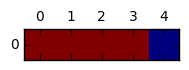

evaluated [('%setVolume', ['turn', 'the', 'volume', 'up'])]
(evaluate) %setVolume ['turn', 'the', 'volume', 'up']


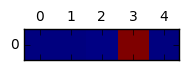

evaluated [('$up_down', ['up'])]
turn the volume up
( parsed
    ( %setVolume
        ( $up_down up ) ) )


In [26]:
walked_flat, walked_tree = walk_tree(parsed, parsed['%'], None)
inputs = [child.key for child in walked_flat.children]
print(inputs, walked_tree)
evaluate_and_print('%', inputs)

(evaluate) % ['hey', 'maia', 'if', 'the', 'ethereum', 'price', 'is', 'less', 'than', '20', 'then', 'turn', 'the', 'living', 'room', 'light', 'on']


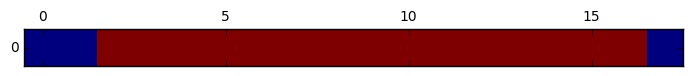

evaluated [('%if', ['if', 'the', 'ethereum', 'price', 'is', 'less', 'than', '20', 'then', 'turn', 'the', 'living', 'room', 'light', 'on'])]
(evaluate) %if ['if', 'the', 'ethereum', 'price', 'is', 'less', 'than', '20', 'then', 'turn', 'the', 'living', 'room', 'light', 'on']


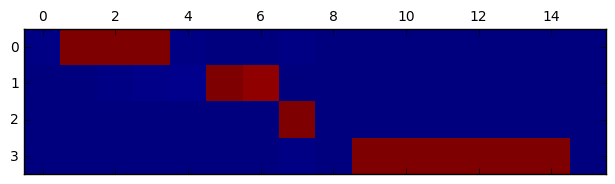

evaluated [('%getPrice', ['the', 'ethereum', 'price']), ('$operator', ['less', 'than']), ('$value', ['20']), ('%setLightState', ['turn', 'the', 'living', 'room', 'light', 'on'])]
(evaluate) %getPrice ['the', 'ethereum', 'price']


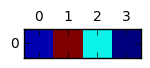

evaluated [('$asset', ['ethereum'])]
(evaluate) %setLightState ['turn', 'the', 'living', 'room', 'light', 'on']


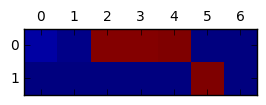

evaluated [('$light', ['living', 'room', 'light']), ('$on_off', ['on'])]
hey maia if the ethereum price is less than 20 then turn the living room light on
( parsed
    ( %if
        ( %getPrice
            ( $asset ethereum ) )
        ( $operator less than )
        ( $value 20 )
        ( %setLightState
            ( $light living room light )
            ( $on_off on ) ) ) )


In [27]:
evaluate_and_print('%', 'hey maia if the ethereum price is less than 20 then turn the living room light on'.split(' '))

(evaluate) % ['hey', 'maia', "what's", 'the', 'ethereum', 'price']


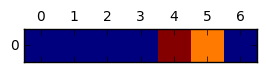

evaluated [('%getPrice', ['ethereum', 'price'])]
(evaluate) %getPrice ['ethereum', 'price']


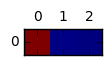

evaluated [('$asset', ['ethereum'])]
hey maia what's the ethereum price
( parsed
    ( %getPrice
        ( $asset ethereum ) ) )


In [32]:
evaluate_and_print('%', 'hey maia what\'s the ethereum price'.split(' '))

(evaluate) % ['hey', 'maia', 'play', 'some', 'Skrillex', 'please', 'and', 'then', 'turn', 'the', 'office', 'light', 'off']


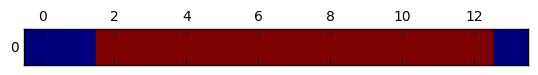

evaluated [('%sequence', ['play', 'some', 'Skrillex', 'please', 'and', 'then', 'turn', 'the', 'office', 'light', 'off'])]
(evaluate) %sequence ['play', 'some', 'Skrillex', 'please', 'and', 'then', 'turn', 'the', 'office', 'light', 'off']


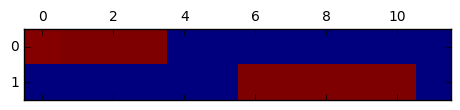

evaluated [('%playMusic', ['play', 'some', 'Skrillex', 'please']), ('%setLightState', ['turn', 'the', 'office', 'light', 'off'])]
(evaluate) %playMusic ['play', 'some', 'Skrillex', 'please']


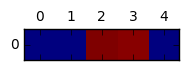

evaluated [('$artist', ['Skrillex', 'please'])]
(evaluate) %setLightState ['turn', 'the', 'office', 'light', 'off']


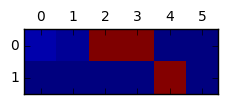

evaluated [('$light', ['office', 'light']), ('$on_off', ['off'])]
hey maia play some Skrillex please and then turn the office light off
( parsed
    ( %sequence
        ( %playMusic
            ( $artist Skrillex please ) )
        ( %setLightState
            ( $light office light )
            ( $on_off off ) ) ) )


In [33]:
evaluate_and_print('%', 'hey maia play some Skrillex please and then turn the office light off'.split(' '))